In [1]:
%matplotlib inline
from ipywidgets import interactive
import matplotlib.pyplot as plt
import numpy as np

from transparentai.datasets import load_iris
from transparentai.models.explainers import ModelExplainer
from sklearn.ensemble import RandomForestClassifier

In [34]:
data = load_iris()
X, Y = data.drop(columns='iris plant'), data['iris plant']
Y = Y.replace({'setosa':0, 'versicolor':1, 'virginica':2})
clf = RandomForestClassifier().fit(X,Y)
explainer = ModelExplainer(clf, X, model_type='tree', multi_label=True)

In [36]:
def plot_local_explain(self, X, feature_classes=None, top=None, num_class=None, **kwargs):
        """
        Display a plot for a local prediction based on X set.

        Parameters
        ----------
        X: pd.DataFrame or np.array
            Data to explain
        feature_classes: dict
            This dictionnary provides new values for categorical feature so
            that the feature can be more interpretable.
            dictionnary with features names as keys and for value
            a dictionnary with key, value pair representing current value
            and value to display.
        num_class: int (default None)
            Class number for which we want to see the explanation
            if it's a binary classification then the value is 1
            if None and it's a multi_label classifier then plots 
            for each class
        """
        values = self.explain_local_influence(X, feature_classes)

        base_value = self._get_base_value()

        if not self.multi_label:
            return self._plot_local_explain(X, values, base_value, top=top)
        else:
            if num_class is None:
                num_class = self.model.predict([X])[0]
            for i, base_val in enumerate(base_value):
                if i != num_class:
                    continue
                # print(f'Plot for the {i}th class probability.')
                self._plot_local_explain(X, values[i], base_val, top=top, num_class=i, **kwargs)

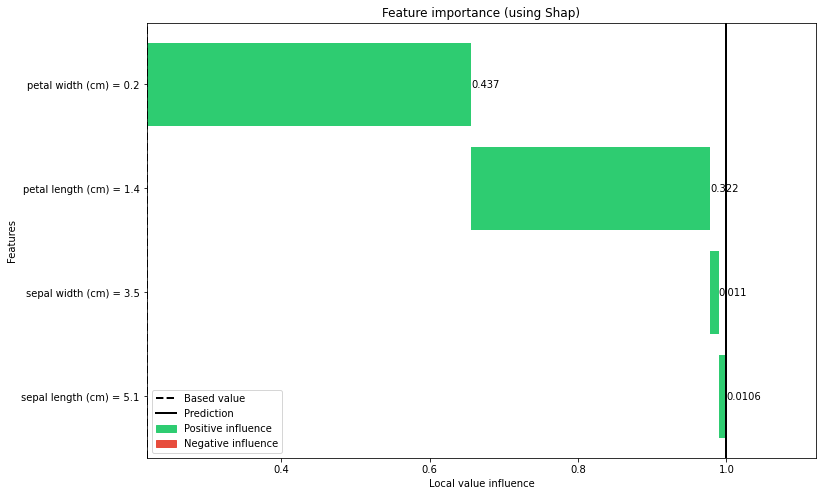

In [38]:
plot_local_explain(explainer, X.iloc[0])

In [41]:
%matplotlib inline
from ipywidgets import interactive
import matplotlib.pyplot as plt
import numpy as np

def f(m, b, title):
    plt.figure(figsize=(15,8))
    x = np.linspace(-10, 10, num=1000)
    plt.plot(x, m * x + b)
    plt.title(title)
    plt.ylim(-5, 5)
    plt.show()

interactive_plot = interactive(f, m=(-2.0, 2.0), 
                                  b=(-3, 3, 0.5), 
                                  title=[('one', 'one'), ('two', 20)])
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=0.0, description='m', max=2.0, min=-2.0), FloatSlider(value=0.0, descr…

In [160]:
import numpy as np
import pandas as pd
import shap
import ipywidgets as widgets
import warnings

import seaborn as sns

from transparentai import utils
from transparentai.models.explainers import explainer_plots as plots


class ModelExplainer():
    """
    Class that allows to understand a local prediction or model behavior using shap_ package.
    For the moment this class will work only for model that TreeExplainer, LinearExplainer
    or KernelExplainer of shap_ package can handle.

    .. _shap : https://github.com/slundberg/shap/
    
    Example
    =======
    
    For binary classification (adult dataset):
    
    >>> from transparentai.datasets import load_adult
    >>> from sklearn.ensemble import RandomForestClassifier

    >>> data = load_adult()
    >>> X, Y = data.drop(columns='income'), data['income'].replace({'>50K':1, '<=50K':0})
    >>> X = X.select_dtypes('number')
    >>> clf = RandomForestClassifier().fit(X,Y)

    >>> explainer = ModelExplainer(clf, X, model_type='tree')
    >>> explainer.explain_global_influence(X, nsamples=1000)
     99%|===================| 1988/2000 [01:01<00:00]        
    {'age': 0.08232147427281439,
     'fnlwgt': 0.051546309804410356,
     'education-num': 0.07579739409175655,
     'capital-gain': 0.07904473020037411,
     'capital-loss': 0.02746167321242212,
     'hours-per-week': 0.060904331971380544}

    >>> explainer.explain_local_influence(X.iloc[0])
    {'age = 25': -0.07041555656760465,
     'fnlwgt = 226802': -0.025452222766471095,
     'education-num = 7': -0.07771055672375951,
     'capital-gain = 0': -0.08661166294186842,
     'capital-loss = 0': 0.005169999992358498,
     'hours-per-week = 40': -0.02528000040561892}

    For multi label classification (iris dataset):
    
    >>> from transparentai.datasets import load_iris
    >>> from sklearn.ensemble import RandomForestClassifier

    >>> data = load_iris()
    >>> X, Y = data.drop(columns='iris plant'), data['iris plant']
    >>> Y = Y.replace({'setosa':0, 'versicolor':1, 'virginica':2})
    >>> clf = RandomForestClassifier().fit(X,Y)

    >>> explainer = ModelExplainer(clf, X, model_type='tree', multi_label=True)
    >>> explainer.explain_global_influence(X)
    {0: {'sepal length (cm)': 0.01175688849131886,
      'sepal width (cm)': 0.005942666575467832,
      'petal length (cm)': 0.22338177293802924,
      'petal width (cm)': 0.16601288524931274},
     1: {'sepal length (cm)': 0.02572877729050815,
      'sepal width (cm)': 0.008901222137936085,
      'petal length (cm)': 0.2281212172475334,
      'petal width (cm)': 0.19257521807807496},
     2: {'sepal length (cm)': 0.02847011091114645,
      'sepal width (cm)': 0.011024999958494059,
      'petal length (cm)': 0.23041677331694704,
      'petal width (cm)': 0.20166499567956975}}

    >>> explainer.explain_local_influence(X.iloc[0])
    {0: {'sepal length (cm) = 5.1': 0.021333332546055316,
      'sepal width (cm) = 3.5': 0.011599999857135118,
      'petal length (cm) = 1.4': 0.42903332408517597,
      'petal width (cm) = 0.2': 0.31883332636673},
     1: {'sepal length (cm) = 5.1': 0.012099999799393118,
      'sepal width (cm) = 3.5': 0.0018000002391636372,
      'petal length (cm) = 1.4': -0.21319999573752285,
      'petal width (cm) = 0.2': -0.15029999669175595},
     2: {'sepal length (cm) = 5.1': -0.03343333344208076,
      'sepal width (cm) = 3.5': -0.013400000038091093,
      'petal length (cm) = 1.4': -0.21583332964917645,
      'petal width (cm) = 0.2': -0.16853333076229318}}
    
    For regression (boston dataset):
    
    
    >>> from transparentai.datasets import load_boston
    >>> from sklearn.linear_model import LinearRegression

    >>> data = load_boston()
    >>> X, Y = data.drop(columns='MEDV'), data['MEDV']
    >>> regr = LinearRegression().fit(X, Y)

    >>> explainer = ModelExplainer(regr, X, model_type='linear')
    >>> explainer.explain_global_influence(X)
    {'CRIM': 0.5167422492788898,
     'ZN': 0.7756203068845728,
     'INDUS': 0.12750516344183324,
     'CHAS': 0.3459732772883547,
     'NOX': 1.7001686711898643,
     'RM': 1.9555806154096416,
     'AGE': 0.017036261147963947,
     'DIS': 2.537086257135257,
     'RAD': 2.3074416123109764,
     'TAX': 1.7711676384532529,
     'PTRATIO': 1.7028349208723197,
     'B': 0.5086851450326836,
     'LSTAT': 2.9991432546436037}

    >>> explainer.explain_local_influence(X.iloc[0])
    {'CRIM = 0.0063': 0.3896189542190243,
     'ZN = 18.0': 0.308063041889274,
     'INDUS = 2.31': -0.18146644441613213,
     'CHAS = 0.0': -0.18584127208907195,
     'NOX = 0.538': 0.29661462781287745,
     'RM = 6.575': 1.1062538448823005,
     'AGE = 65.2': -0.002336189759535761,
     'DIS = 4.09': -0.4352292308278341,
     'RAD = 1.0': -2.616541593062981,
     'TAX = 296.0': 1.3843997187946957,
     'PTRATIO = 15.3': 3.006425898946704,
     'B = 396.9': 0.37457147693105614,
     'LSTAT = 4.98': 4.026504219585754}
    
    
    Attributes
    ----------
    model_type:
        Type of model to inspect, it can only be 'tree', 'linear' or None
    model:
        model to inspect
    multi_label: bool
        Whether there is more than 2 classes in the label column
        (only for classification)
    explainer: shap.TreeExplainer, shap.LinearExplainer or shap.KernelExplainer
        explainer object that has expected values and can
        compute shap values 
    feature_names: np.array
        list of feature names (length == length of X columns)
    global_explain: dict
        dictionnary with feature names as keys and
        global feature importance as values 
    
    """
    
    def __init__(self, model, X, model_type=None, feature_names=None, multi_label=False):
        """
        Parameters
        ----------
        model:
            model to inspect
        X: array like
            data (possibly training) to start the explainer
        model_type: str (default None)
            Type of model to inspect, it can only be 'tree', 'linear' or None
        feature_names: np.array or list
            list of feature names (length == length of X columns)
        multi_label: bool
            Whether there is more than 2 classes in the label column
            (only for classification)

        Raises
        ------
        TypeError:
            X must be an array like. Valids dtypes are pandas.DataFrame,
            pandas.Series, numpy.ndarray and list
        ValueError:
            model_type must be 'tree', 'linear' or None
        AttributeError:
            model has neither a predict() function or a predict_proba() function
        """
        if type(X) not in [pd.DataFrame, pd.Series, np.ndarray, list]:
            raise TypeError('X must be an array like. Valids dtypes are pandas.DataFrame, pandas.Series, numpy.ndarray and list')
        if (model_type is not None) & (model_type not in ['tree','linear']):
            raise ValueError('model_type must be \'tree\', \'linear\' or None')

        if (utils.object_has_function(model, 'predict_proba')):
            if (model_type == 'tree'):
                f = lambda x: model.predict_proba(x)
            else:
                f = lambda x: model.predict_proba(x)[:,1]
        elif utils.object_has_function(model, 'predict'):
            f = model.predict
        else:
            raise AttributeError('model has neither a predict() function or a predict_proba() function')
        
        if type(X) in [np.ndarray,list]:
            X = pd.DataFrame(X, columns=feature_names)
        elif type(X) == pd.Series:
            X = X.to_frame()
        
        self.feature_names = X.columns.values.tolist()
        self.kwargs_dict = self._generate_kwargs_interactive_dict(X)

        # Use kmeans to sample dataset to 50 'representative' rows
        # to precompute the explainer.
        if (model_type is None) | (model_type in ['tree']):
            K = 50
            K = K if len(X) > K else len(X)
            X = shap.kmeans(X, K) 
        
        self.model = model
        self.model_type = model_type
        self.predict = f
        self.multi_label = multi_label
        self.explainer = self.init_explainer(X)
        
        self.global_explain = None
        
        
    def init_explainer(self, X):
        """Initialize the explainer.
        
        If model_type is None then use shap.KernelExplainer class.
        
        Else if it's 'tree' then shap.TreeExplainer.
        
        Else use shap.LinearExplainer.
        
        Parameters
        ----------
        X: array like
            data (possibly training) to start the explainer
        
        Returns
        -------
        shap.KernelExplainer, shap.TreeExplainer, shap.LinearExplainer:
            explainer initialized
        """
        if self.model_type is None:
            explainer = shap.KernelExplainer(self.predict, X)        
        elif self.model_type == 'tree':
            explainer = shap.TreeExplainer(self.model, X)
        else:
            explainer = shap.LinearExplainer(self.model, X)

        return explainer

    def _generate_kwargs_interactive_dict(self, X):
        """
        """
        X = np.array(X)

        kwargs = {}
        for i,f in enumerate(self.feature_names):
            values = X[:,i]
            kwargs[f] = {}
            
            if values.dtype in [int,np.int16,np.int32,np.int64]:
                widget = widgets.IntText
            elif values.dtype in [float,np.float16,np.float32,np.float64]:
                widget = widgets.FloatText
            else:
                widget = widgets.Text
            
            kwargs[f]['widget'] = widget

        return kwargs

    def _get_kwargs_interactive(self, X):
        """
        """
        kwargs = {}
        style = {'description_width': 'initial'}

        for i,f in enumerate(explainer.feature_names):
            widget = self.kwargs_dict[f]['widget']
            kwargs[f] = widget(value=X[i], description=f, style=style)
            
        return kwargs
    
    def compute_shap_values(self, X):
        """Computes the shap values using explainer attribute.
        
        Parameters
        ----------
        X: array like
            A matrix of samples (# samples x # features) 
            on which to explain the model's output.

        Returns
        -------
        np.ndarray:
            For models with a single output this returns a matrix of SHAP values
            (# samples x # features). Each row sums to the difference between the model output for that
            sample and the expected value of the model output (which is stored as expected_value
            attribute of the explainer). For models with vector outputs this returns a list
            of such matrices, one for each output.
        """
        if self.model_type is None:     
            shap_values = self.explainer.shap_values(X, l1_reg='aic')
        elif self.model_type == 'tree':
            shap_values = self.explainer.shap_values(X, check_additivity=False)
        else:
            shap_values = self.explainer.shap_values(X)

        return shap_values
    
    def _get_base_value(self):
        """
        Returns base value from the explainer attribute.

        Returns
        -------
        np.array
            Array with all expected values. If it's a tree explainer and
            a binary classification then it returns for only the class 1
        """
        if (self.model_type == 'tree') & (not self.multi_label):
            return self.explainer.expected_value[1]
        else:
            return self.explainer.expected_value

    def _get_predictions(self, X, num_class=1):
        """
        Returns the prediction using `predict_proba` function if it exists
        else it uses predict function. 

        Parameters
        ----------
        X: pd.DataFrame or np.array
            Data to explain
        num_class: int (default 1)
            Class number for which we want to see the explanation
            if it's a binary classification then the value is 1

        Returns
        -------
        number:
            prediction
        """
        if self.model_type == 'tree':
            return self.predict([X])[0][num_class]
        else:
            return self.predict([X])[0]
    
    def explain_global_influence(self, X, nsamples=None):
        """Global explaination for a model based on a sample X
        If there are a lot of data this function could last a while.

        Parameters
        ----------
        X: array like
            Data to explain   
        nsamples: None or int or float (default None)
            If not None reduce the data to a sample of nsamples 
            else if <= 1. reduce to len(df) * nsamples 

        Returns
        -------
        dict:
            dictionnary with feature names as keys and
            feature importance as values 
            
        Raises
        ------
        TypeError:
            X must be an array like. Valids dtypes are pandas.DataFrame, 
            pandas.Series, numpy.ndarray and list
        ValueError:
            X must have the same number of feature than the 
            X used in the class initialization
        """
        if type(X) not in [pd.DataFrame, pd.Series, np.ndarray, list]:
            raise TypeError('X must be an array like. Valids dtypes are pandas.DataFrame, pandas.Series, numpy.ndarray and list')
        if np.array(X).shape[1] != len(self.feature_names):
            raise ValueError('X must have the same number of feature than the X used in the class initialization')
        
        # Reduce X if nsample is set
        if nsamples is not None:
            if nsamples <= 1.:
                nsamples = int(len(X)*nsamples)
            elif nsamples > len(X):
                nsamples = len(X)
            X = X.sample(nsamples)
        
        shap_values = self.compute_shap_values(X)

        res = {}
        if not self.multi_label:
            if self.model_type == 'tree':
                shap_values = shap_values[1]

            res = pd.DataFrame(shap_values, columns=self.feature_names)
            res = res.abs().mean().to_dict()
        else:
            for i in range(0, len(shap_values)):
                res[i] = pd.DataFrame(shap_values[i], columns=self.feature_names)
                res[i] = res[i].abs().mean().to_dict()
                
        self.global_explain = res
        return res   
    
    def explain_local_influence(self, X, feature_classes=None):
        """Explain a local prediction : only one row required.

        Parameters
        ----------
        X: array like
            Data to explain with column names as indexes
        feature_classes: dict
            This dictionnary provides new values for categorical feature so
            that the feature can be more interpretable.
            dictionnary with features names as keys and for value
            a dictionnary with key, value pair representing current value
            and value to display.

        Returns
        -------
        dict:
            dictionnary with feature names as keys and
            feature importance as values

        Raises
        ------
        TypeError:
            X must be an array like. Valids dtypes are pandas.DataFrame, 
            pandas.Series, numpy.ndarray and list
        ValueError:
            X must be one row
        ValueError:
            X must have the same number of feature than 
            the X used in the class initialization
        """
        if type(X) not in [pd.DataFrame, pd.Series, np.ndarray, list]:
            raise TypeError('X must be an array like. Valids dtypes are pandas.DataFrame, pandas.Series, numpy.ndarray and list')
        elif type(X) == pd.DataFrame:
            X = X.T
            
        X = np.array(X)
        if len(X.shape) > 1:
            if X.shape[1] > 1:
                raise ValueError('X must be one row')
        if len(X) != len(self.feature_names):
            raise ValueError('X must have the same number of feature than the X used in the class initialization')
        
        feature_names = list()
        
        if feature_classes is not None:
            valid_features = [feat for feat in feature_classes if feat in X.index]
            for f, v in zip(self.feature_names, X):
                if f not in valid_features:
                    feature_names.append(f'{f} = {v}')
                else:
                    feature_names.append(
                        f'{f} = {feature_classes[f][v]}')
        else:
            for f, v in zip(self.feature_names, X):
                v = str(round(v,4))
                feature_names.append('%s = %s'%(f, v))
        
        shap_values = self.compute_shap_values(X)
        
        if not self.multi_label:
            if self.model_type == 'tree':
                shap_values = shap_values[1]
            return dict(zip(feature_names, shap_values))
        else:
            res = {}
            for i, values in enumerate(shap_values):
                res[i] = dict(zip(feature_names, values))
            return res
        

    def format_feature_importance(self, feat_importance, top=None):
        """
        Format feature importance with a top value so that it returns only
        the features that have the biggest influence

        Parameters
        ----------
        feat_importance: pd.Series or dict
            current feature importance
        top: int
            number of value to get

        Returns
        -------
        pd.Series
            Feature importance formated
        """
        if type(feat_importance) not in [pd.Series, dict]:
            raise TypeError('feat_importance must be a pandas.Series or dict')
        
        if type(feat_importance) == dict:
            feat_importance = pd.Series(feat_importance)

        feat_importance = feat_importance.sort_values()

        if top is None:
            top = len(feat_importance)
        elif top > len(feat_importance):
            top = len(feat_importance)

        top_index = feat_importance.abs().sort_values(
            ascending=False).index[0:top]
        other_index = feat_importance.abs().sort_values(
            ascending=False).index[top:]

        feat_importance_filtered = feat_importance.loc[top_index].sort_values()
        if len(other_index) > 0:
            feat_importance_filtered['Others variables'] = feat_importance.loc[other_index].sum(
            )

        return feat_importance_filtered.sort_values()
    
        
    def _plot_local_explain(self, X, values, base_value, top=None, num_class=1, **kwargs):
        """
        Display local feature influence sorted for a specific
        prediction.
        
        Parameters
        ----------
        X: pd.DataFrame or np.array
            Data to explain
        values: pd.Series
            Feature importance with feature as indexes and 
            shap value as values
        base_value: number
            prediction value if we don't put any feature into the model
        top: int
            top n feature to display (in case there are too
            much features)
        num_class: int (default 1)
            Class number for which we want to see the explanation
            if it's a binary classification then the value is 1
        """
        values = self.format_feature_importance(values, top=top)
        pred = self._get_predictions(X, num_class=num_class)
        pred_class = self.model.predict([X])[0]

        return plots.plot_local_feature_influence(
            feat_importance=values, base_value=base_value, pred=pred, pred_class=pred_class, **kwargs)

    def plot_local_explain(self, X, feature_classes=None, top=None, num_class=None, **kwargs):
        """
        Display a plot for a local prediction based on X set.

        Parameters
        ----------
        X: pd.DataFrame or np.array
            Data to explain
        feature_classes: dict
            This dictionnary provides new values for categorical feature so
            that the feature can be more interpretable.
            dictionnary with features names as keys and for value
            a dictionnary with key, value pair representing current value
            and value to display.
        num_class: int (default None)
            Class number for which we want to see the explanation
            if it's a binary classification then the value is 1
            if None and it's a multi_label classifier then plots 
            for each class
        """
        values = self.explain_local_influence(X, feature_classes)

        base_value = self._get_base_value()

        if not self.multi_label:
            return self._plot_local_explain(X, values, base_value, top=top)
        else:
            if num_class is None:
                num_class = self.model.predict([X])[0]
            for i, base_val in enumerate(base_value):
                if i != num_class:
                    continue
                # print(f'Plot for the {i}th class probability.')
                self._plot_local_explain(X, values[i], base_val, top=top, num_class=i, **kwargs)
                
    

    def plot_local_explain_interact(self, X, feature_classes=None, visible_feat=None,
                                    top=None, num_class=None, **kwargs):
        """
        Display a plot for a local prediction based on X set.

        Parameters
        ----------
        X: pd.DataFrame or np.array
            Data to explain
        feature_classes: dict
            This dictionnary provides new values for categorical feature so
            that the feature can be more interpretable.
            dictionnary with features names as keys and for value
            a dictionnary with key, value pair representing current value
            and value to display.
        num_class: int (default None)
            Class number for which we want to see the explanation
            if it's a binary classification then the value is 1
            if None and it's a multi_label classifier then plots 
            for each class
        """                
        base_value = self._get_base_value()
        
        def plots(**keywords):
            x = X.copy()
            x = np.array(x)
            for k, v in keywords.items():
                i = np.where(np.array(self.feature_names) == k)
                x[i] = v
        
            values = self.explain_local_influence(x, feature_classes)
            
            if not self.multi_label:
                return self._plot_local_explain(x, values, base_value, top=top, **kwargs)
            else:
                if num_class is None:
                    num_c = self.model.predict([x])[0]
                else:
                    num_c = num_class
                for i, base_val in enumerate(base_value):
                    if i != num_c:
                        continue
                    # print(f'Plot for the {i}th class probability.')
                    return self._plot_local_explain(x, values[i], base_val, top=top, num_class=i, **kwargs)
        
        args = self._get_kwargs_interactive(X)
        
        if visible_feat is not None:
            new = {}
            for feat in visible_feat:
                if feat not in self.feature_names:
                    warnings.warn('%s feature ignored because it is not in feature_names'%(feat))
                    continue
                new[feat] = args[feat]
            args = new
        
        interactive_plot = widgets.interactive(plots, **args)
        return interactive_plot
                
         
    def plot_global_explain(self, X=None, nsamples=None, top=None, color='#3498db', **kwargs):
        """
        Display a plot for model global explanation based on 
        a sample X.

        Parameters
        ----------
        X: pd.DataFrame or np.array
            Data to explain
        nsamples: None or int or float (default None)
            If not None reduce the data to a sample of nsamples 
            else if <= 1. reduce to len(df) * nsamples
        top: int
            top n feature to display (in case there are too
            much features)
        color str (default '#3498db')
            Color of the bar plot
        
        Raises
        ------
        AttributeError:
            If X parameter is None then you have to add X in explain_global function first
            or directly in this function if you prefer to plot directly.
        """
        if X is not None:
            self.explain_global_influence(X, nsamples)
        elif self.global_explain is None:
            raise AttributeError(
                'Please set a X value first, using X parameter in this function or inside explain_global_influence function')

        values = self.global_explain
        if not self.multi_label:
            values = self.format_feature_importance(values, top=top)
            return plots.plot_global_feature_influence(feat_importance=values, color=color, **kwargs)
        else:
            res = list()
            for i in range(0, len(values)):
                val = self.format_feature_importance(values[i], top=top)
                res.append(val)
            res = pd.concat(res, axis=1)
            
            if not ((type(color) == list) & (len(color) == len(values))):
                color = sns.color_palette("colorblind", len(values))
                
            return plots.plot_global_feature_influence(feat_importance=res, color=color, **kwargs)
          

In [166]:
pip freeze | grep ipywidgets

ipywidgets==7.5.1
Note: you may need to restart the kernel to use updated packages.


In [161]:
data = load_iris()
X, Y = data.drop(columns='iris plant'), data['iris plant']
Y = Y.replace({'setosa':0, 'versicolor':1, 'virginica':2})
clf = RandomForestClassifier().fit(X,Y)
explainer = ModelExplainer(clf, X, model_type='tree', multi_label=True)

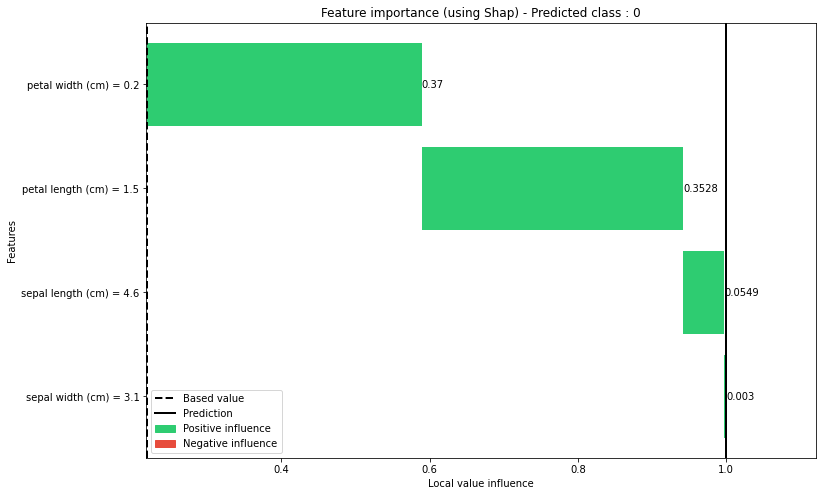

In [162]:
row = X.iloc[3]
explainer.plot_local_explain(row)

In [164]:
explainer.plot_local_explain_interact(row, visible_feat=['sepal length (cm)','sepal width (cm)'])

interactive(children=(FloatText(value=4.6, description='sepal length (cm)', style=DescriptionStyle(description…

In [59]:
from transparentai.datasets import load_adult
from sklearn.ensemble import RandomForestClassifier

data = load_adult()
X, Y = data.drop(columns='income'), data['income'].replace({'>50K':1, '<=50K':0})
X = X.select_dtypes('number')
clf = RandomForestClassifier().fit(X,Y)


In [60]:
explainer = ModelExplainer(clf, X, model_type='tree')

In [61]:
row = X.iloc[42]
explainer.plot_local_explain_interact(row)

interactive(children=(IntText(value=36, description='age', style=DescriptionStyle(description_width='initial')…

In [120]:
from transparentai.datasets import load_boston
from sklearn.linear_model import LinearRegression

data = load_boston()
X, Y = data.drop(columns='MEDV'), data['MEDV']
regr = LinearRegression().fit(X, Y)

explainer = ModelExplainer(regr, X, model_type='linear')

In [121]:
row = X.iloc[42]
explainer.plot_local_explain_interact(row, top=3)

interactive(children=(FloatText(value=0.1415, description='CRIM', style=DescriptionStyle(description_width='in…